In [2]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from matplotlib import pyplot as plt

import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor()])

batch_size = 100

trainset = CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(len(trainset)) #50,000 images all 32x32 and 3 RGB
print(len(testset)) #10,000 images

50000
10000


In [6]:
import torchvision.utils as vutils
def get_image(index):
    image, label = trainloader.dataset.__getitem__(index)
    plt.imshow(vutils.make_grid(image, normalize=True).numpy().transpose((1,2,0)))
    plt.xlabel(classes[label])

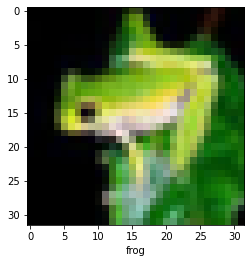

In [21]:
get_image(104)

In [7]:
trainset[0]

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss ###PERHAPS THIS IS A PROBLEM LOOK AT THE INPUT AND WHAT THE STRUCTURE OF INPUTT MUST BE
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [9]:
# Defining the model
init_channels = 6
kernel_size = 3

class ClassificationModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, out_channels=init_channels, kernel_size=kernel_size, padding=0), #30x30x6
            nn.ReLU(),
            nn.Conv2d(init_channels, out_channels=init_channels*2, kernel_size=kernel_size, padding=0), #28x28x12
            nn.ReLU(),
            nn.Conv2d(init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, padding=0), #26x26x24
            nn.ReLU(),
            nn.Conv2d(init_channels*4, out_channels=init_channels, kernel_size=kernel_size, padding=0), #24x24x6

            nn.Flatten(),
            nn.Linear(24*24*6, 120),
            nn.ReLU(),
            nn.Linear(120, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
    )
    def forward(self, xb):
        return self.cnn(xb)

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [18]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = .001
model = ClassificationModel()

history = fit(num_epochs, lr, model, trainloader, testloader, opt_func)

Epoch [0], train_loss: 1.7635, val_loss: 1.5296, val_acc: 0.4464
Epoch [1], train_loss: 1.4297, val_loss: 1.3499, val_acc: 0.5156
Epoch [2], train_loss: 1.3048, val_loss: 1.2886, val_acc: 0.5356
Epoch [3], train_loss: 1.2177, val_loss: 1.2519, val_acc: 0.5501
Epoch [4], train_loss: 1.1534, val_loss: 1.2181, val_acc: 0.5606
Epoch [5], train_loss: 1.0824, val_loss: 1.2429, val_acc: 0.5657
Epoch [6], train_loss: 1.0067, val_loss: 1.1653, val_acc: 0.5952
Epoch [7], train_loss: 0.9397, val_loss: 1.1123, val_acc: 0.6085
Epoch [8], train_loss: 0.8759, val_loss: 1.1065, val_acc: 0.6149
Epoch [9], train_loss: 0.8126, val_loss: 1.1355, val_acc: 0.6098


In [41]:
number_correct = 0
for images, labels in testloader:
    outputs = model(images)
    
    #print(outputs)
    predictions = torch.argmax(outputs, dim=1)
    #print(predictions)
    #print(labels.data)
    number_correct += torch.sum(predictions == labels.data)
    #print(number_correct)
    
accuracy = 100*number_correct/len(testloader.dataset)
print("accuracy = " + str(accuracy.numpy()))

60.98
accuracy = 60.98
